# Facial Expression Recognition

#### The dataset consists of 48 x 48 grayscale images belonging to 8 different classes. I have trained a basic CNN model on 5 folds for 25 epochs.    

#### Model architecture copied from https://www.kaggle.com/prajwalsood/extended-and-augmented-google-fer-starter

In [1]:
import os
import numpy as np
from tqdm import tqdm
from glob import glob
from cv2 import imread
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from torch.nn import functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader,SubsetRandomSampler,ConcatDataset

### Config

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_path = '../input/google-fer-image-format/train'
test_path = '../input/google-fer-image-format/val'
num_epochs = 25
batch_size = 128
k = 5
emotions = sorted(os.listdir(train_path))

In [3]:
print(emotions)

['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS', 'NEUTRAL', 'SADNESS', 'SURPRISE']


### Dataset class

In [4]:
class face_dataset(Dataset):
    def __init__(self,path,augmentation):
        
        self.augmentation = augmentation
        
        self.transform1 = T.Compose([
            T.ToPILImage(),
            T.Grayscale(num_output_channels=1)
            ])
               
        self.augment = A.Compose([            
            A.augmentations.geometric.rotate.Rotate(limit = (-5,5),p = 0.5),
            A.augmentations.transforms.GaussNoise()  
            ])
        
        self.transform2 = T.Compose([
            T.ToTensor(),
            T.Normalize([0.5],[0.5])
            ])
        
        self.images = []
        self.labels = []
        
        for i,emotion in enumerate(emotions):
            image_paths = glob(f'{path}/{emotion}/*.jpg')
            self.images.extend(image_paths)
            self.labels.extend([i]*len(image_paths))

    def __len__(self):
        return (len(self.images))
    
    def __getitem__(self, i):
        image = imread(self.images[i])
        label = self.labels[i]
        
        image = self.transform1(image)
        if self.augmentation:
            image = self.augment(image = np.array(image))['image']
        image = self.transform2(image)
    
        return image,label    

### Train dataset

In [5]:
train = face_dataset(train_path,False)
augmented = face_dataset(train_path,True)
targets = np.array(train.labels * 2)
train = ConcatDataset([train,augmented])
print(len(train))

65290


### Test dataset

In [6]:
test = face_dataset(test_path,False)
print(len(test))
test_data_loader = DataLoader(dataset = test, batch_size = batch_size, shuffle=True, num_workers=4)

8166


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Plotting a random image

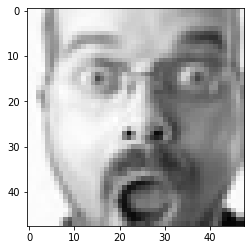

SURPRISE


In [7]:
x,y = train[65000]
arr = x.numpy().reshape(48,48)
plt.imshow(arr, cmap = 'gray')
plt.show()
print(emotions[y])

### Defining functions for training and validation epochs

In [8]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images,labels in tqdm(dataloader):
        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images,labels = images.to(device),labels.to(device)
            output = model(images)
            loss=loss_fn(output,labels)
            valid_loss+=loss.item()*images.size(0)
            scores, predictions = torch.max(output.data,1)
            val_correct+=(predictions == labels).sum().item()
    return valid_loss,val_correct

### Model Architecture

In [9]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
      
        self.c1 = nn.Conv2d(1,32,3,padding = 1)
        self.c2 = nn.Conv2d(32,64,3,padding = 1)
        self.c3 = nn.Conv2d(64,128,5,padding = 2)
        self.c4 = nn.Conv2d(128,512,3,padding = 1)
        self.c5 = nn.Conv2d(512,512,3,padding = 1)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(512)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.bn6 = nn.BatchNorm1d(512) 
        
        self.l1 = nn.Linear(512*3*3,256)   
        self.l2 = nn.Linear(256,512)      
        self.l3 = nn.Linear(512,8)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        
        
    def forward(self, x):
        x = F.relu(self.c1(x)) 
        x = F.relu(self.c2(x)) 
        x = self.dropout(self.pool(self.bn1(x)))
        x = F.relu(self.c3(x))
        x = self.dropout(self.pool(self.bn2(x)))
        x = F.relu(self.c4(x))
        x = self.dropout(self.pool(self.bn3(x)))
        x = F.relu(self.c5(x))
        x = self.dropout(self.pool(self.bn4(x)))
    
        x = x.view(-1, 512 * 3 * 3)            
        x = self.bn5(F.relu(self.l1(x)))              
        x = self.bn6(F.relu(self.l2(x)))               
        x = self.l3(x) 
        return x

criterion = nn.CrossEntropyLoss()

### Training and evaluating model through cross validation 

In [10]:
models_list = []
foldperf = {}
val_correct = 0
splits = StratifiedKFold(n_splits = k,shuffle = True,random_state = 42)

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(train)),targets)):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train, batch_size = batch_size, sampler = train_sampler)
    val_loader = DataLoader(train, batch_size = batch_size, sampler = val_sampler)
        
    model = ConvNet2()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.002)
    step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct = train_epoch(model,device,train_loader,criterion,optimizer)
        val_loss, val_correct = valid_epoch(model,device,val_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        val_loss = val_loss / len(val_loader.sampler)
        val_acc = val_correct / len(val_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Validation Loss:{:.3f} AVG Training Acc {:.2f} % AVG Validation Acc {:.2f} %"
              .format(epoch + 1,num_epochs,train_loss,val_loss, train_acc, val_acc))
        
        history['train_loss'].append(train_loss)
        history['test_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(val_acc)
        
        step_lr_scheduler.step()
    models_list.append(model)

    foldperf['fold{}'.format(fold+1)] = history  

    #saving model
#     checkpoint = {'model': ConvNet2(),
#                   'state_dict': model.state_dict(),
#                   'optimizer' : optimizer.state_dict()}

#     torch.save(checkpoint, f'checkpoint{fold+1}.pth')

Fold 1


100%|██████████| 409/409 [02:49<00:00,  2.42it/s]


Epoch:1/25 AVG Training Loss:1.501 AVG Validation Loss:1.269 AVG Training Acc 41.25 % AVG Validation Acc 51.42 %


100%|██████████| 409/409 [01:23<00:00,  4.92it/s]


Epoch:2/25 AVG Training Loss:1.131 AVG Validation Loss:1.084 AVG Training Acc 56.85 % AVG Validation Acc 58.79 %


100%|██████████| 409/409 [01:23<00:00,  4.90it/s]


Epoch:3/25 AVG Training Loss:0.977 AVG Validation Loss:0.996 AVG Training Acc 63.05 % AVG Validation Acc 62.99 %


100%|██████████| 409/409 [01:27<00:00,  4.68it/s]


Epoch:4/25 AVG Training Loss:0.891 AVG Validation Loss:0.955 AVG Training Acc 66.61 % AVG Validation Acc 64.73 %


100%|██████████| 409/409 [01:23<00:00,  4.89it/s]


Epoch:5/25 AVG Training Loss:0.761 AVG Validation Loss:0.848 AVG Training Acc 71.94 % AVG Validation Acc 69.42 %


100%|██████████| 409/409 [01:23<00:00,  4.89it/s]


Epoch:6/25 AVG Training Loss:0.686 AVG Validation Loss:0.793 AVG Training Acc 74.88 % AVG Validation Acc 72.23 %


100%|██████████| 409/409 [01:23<00:00,  4.90it/s]


Epoch:7/25 AVG Training Loss:0.603 AVG Validation Loss:0.830 AVG Training Acc 77.96 % AVG Validation Acc 70.00 %


100%|██████████| 409/409 [01:24<00:00,  4.86it/s]


Epoch:8/25 AVG Training Loss:0.474 AVG Validation Loss:0.727 AVG Training Acc 83.02 % AVG Validation Acc 74.88 %


100%|██████████| 409/409 [01:34<00:00,  4.34it/s]


Epoch:9/25 AVG Training Loss:0.384 AVG Validation Loss:0.681 AVG Training Acc 86.22 % AVG Validation Acc 77.09 %


100%|██████████| 409/409 [01:36<00:00,  4.24it/s]


Epoch:10/25 AVG Training Loss:0.332 AVG Validation Loss:0.671 AVG Training Acc 88.22 % AVG Validation Acc 78.35 %


100%|██████████| 409/409 [01:37<00:00,  4.18it/s]


Epoch:11/25 AVG Training Loss:0.294 AVG Validation Loss:0.649 AVG Training Acc 89.69 % AVG Validation Acc 79.19 %


100%|██████████| 409/409 [01:37<00:00,  4.19it/s]


Epoch:12/25 AVG Training Loss:0.260 AVG Validation Loss:0.633 AVG Training Acc 90.88 % AVG Validation Acc 80.37 %


100%|██████████| 409/409 [01:27<00:00,  4.66it/s]


Epoch:13/25 AVG Training Loss:0.237 AVG Validation Loss:0.613 AVG Training Acc 91.70 % AVG Validation Acc 81.45 %


100%|██████████| 409/409 [01:26<00:00,  4.74it/s]


Epoch:14/25 AVG Training Loss:0.220 AVG Validation Loss:0.601 AVG Training Acc 92.30 % AVG Validation Acc 82.36 %


100%|██████████| 409/409 [01:22<00:00,  4.93it/s]


Epoch:15/25 AVG Training Loss:0.195 AVG Validation Loss:0.600 AVG Training Acc 93.15 % AVG Validation Acc 82.13 %


100%|██████████| 409/409 [01:23<00:00,  4.91it/s]


Epoch:16/25 AVG Training Loss:0.189 AVG Validation Loss:0.600 AVG Training Acc 93.39 % AVG Validation Acc 81.97 %


100%|██████████| 409/409 [01:23<00:00,  4.90it/s]


Epoch:17/25 AVG Training Loss:0.188 AVG Validation Loss:0.585 AVG Training Acc 93.45 % AVG Validation Acc 82.33 %


100%|██████████| 409/409 [01:23<00:00,  4.88it/s]


Epoch:18/25 AVG Training Loss:0.185 AVG Validation Loss:0.592 AVG Training Acc 93.48 % AVG Validation Acc 82.64 %


100%|██████████| 409/409 [01:24<00:00,  4.85it/s]


Epoch:19/25 AVG Training Loss:0.182 AVG Validation Loss:0.607 AVG Training Acc 93.72 % AVG Validation Acc 82.34 %


100%|██████████| 409/409 [01:23<00:00,  4.89it/s]


Epoch:20/25 AVG Training Loss:0.179 AVG Validation Loss:0.584 AVG Training Acc 93.77 % AVG Validation Acc 83.32 %


100%|██████████| 409/409 [01:24<00:00,  4.85it/s]


Epoch:21/25 AVG Training Loss:0.178 AVG Validation Loss:0.588 AVG Training Acc 93.71 % AVG Validation Acc 82.65 %


100%|██████████| 409/409 [01:27<00:00,  4.65it/s]


Epoch:22/25 AVG Training Loss:0.176 AVG Validation Loss:0.585 AVG Training Acc 93.89 % AVG Validation Acc 83.17 %


100%|██████████| 409/409 [01:23<00:00,  4.88it/s]


Epoch:23/25 AVG Training Loss:0.176 AVG Validation Loss:0.588 AVG Training Acc 93.85 % AVG Validation Acc 83.05 %


100%|██████████| 409/409 [01:25<00:00,  4.80it/s]


Epoch:24/25 AVG Training Loss:0.173 AVG Validation Loss:0.590 AVG Training Acc 93.98 % AVG Validation Acc 83.14 %


100%|██████████| 409/409 [01:25<00:00,  4.77it/s]


Epoch:25/25 AVG Training Loss:0.173 AVG Validation Loss:0.581 AVG Training Acc 94.07 % AVG Validation Acc 83.19 %
Fold 2


100%|██████████| 409/409 [01:23<00:00,  4.89it/s]


Epoch:1/25 AVG Training Loss:1.540 AVG Validation Loss:1.317 AVG Training Acc 39.44 % AVG Validation Acc 49.54 %


100%|██████████| 409/409 [01:43<00:00,  3.94it/s]


Epoch:2/25 AVG Training Loss:1.155 AVG Validation Loss:1.082 AVG Training Acc 55.54 % AVG Validation Acc 59.04 %


100%|██████████| 409/409 [01:22<00:00,  4.96it/s]


Epoch:3/25 AVG Training Loss:1.052 AVG Validation Loss:0.984 AVG Training Acc 59.92 % AVG Validation Acc 62.68 %


100%|██████████| 409/409 [01:23<00:00,  4.93it/s]


Epoch:4/25 AVG Training Loss:0.906 AVG Validation Loss:0.900 AVG Training Acc 66.32 % AVG Validation Acc 66.59 %


100%|██████████| 409/409 [01:23<00:00,  4.91it/s]


Epoch:5/25 AVG Training Loss:0.779 AVG Validation Loss:0.852 AVG Training Acc 71.33 % AVG Validation Acc 68.62 %


100%|██████████| 409/409 [01:24<00:00,  4.85it/s]


Epoch:6/25 AVG Training Loss:0.729 AVG Validation Loss:0.849 AVG Training Acc 73.23 % AVG Validation Acc 69.18 %


100%|██████████| 409/409 [01:23<00:00,  4.88it/s]


Epoch:7/25 AVG Training Loss:0.617 AVG Validation Loss:0.778 AVG Training Acc 77.67 % AVG Validation Acc 72.28 %


100%|██████████| 409/409 [01:23<00:00,  4.87it/s]


Epoch:8/25 AVG Training Loss:0.459 AVG Validation Loss:0.687 AVG Training Acc 83.69 % AVG Validation Acc 76.29 %


100%|██████████| 409/409 [01:25<00:00,  4.80it/s]


Epoch:9/25 AVG Training Loss:0.373 AVG Validation Loss:0.678 AVG Training Acc 86.71 % AVG Validation Acc 77.09 %


100%|██████████| 409/409 [01:24<00:00,  4.84it/s]


Epoch:10/25 AVG Training Loss:0.325 AVG Validation Loss:0.657 AVG Training Acc 88.57 % AVG Validation Acc 78.34 %


100%|██████████| 409/409 [01:23<00:00,  4.92it/s]


Epoch:11/25 AVG Training Loss:0.290 AVG Validation Loss:0.634 AVG Training Acc 89.87 % AVG Validation Acc 79.48 %


100%|██████████| 409/409 [01:23<00:00,  4.90it/s]


Epoch:12/25 AVG Training Loss:0.259 AVG Validation Loss:0.626 AVG Training Acc 90.98 % AVG Validation Acc 80.28 %


100%|██████████| 409/409 [01:24<00:00,  4.85it/s]


Epoch:13/25 AVG Training Loss:0.235 AVG Validation Loss:0.610 AVG Training Acc 91.87 % AVG Validation Acc 80.91 %


100%|██████████| 409/409 [01:24<00:00,  4.83it/s]


Epoch:14/25 AVG Training Loss:0.218 AVG Validation Loss:0.583 AVG Training Acc 92.27 % AVG Validation Acc 82.04 %


100%|██████████| 409/409 [01:24<00:00,  4.86it/s]


Epoch:15/25 AVG Training Loss:0.194 AVG Validation Loss:0.586 AVG Training Acc 93.25 % AVG Validation Acc 82.03 %


100%|██████████| 409/409 [01:24<00:00,  4.86it/s]


Epoch:16/25 AVG Training Loss:0.194 AVG Validation Loss:0.578 AVG Training Acc 93.20 % AVG Validation Acc 82.62 %


100%|██████████| 409/409 [01:22<00:00,  4.93it/s]


Epoch:17/25 AVG Training Loss:0.190 AVG Validation Loss:0.601 AVG Training Acc 93.51 % AVG Validation Acc 82.25 %


100%|██████████| 409/409 [01:23<00:00,  4.90it/s]


Epoch:18/25 AVG Training Loss:0.184 AVG Validation Loss:0.588 AVG Training Acc 93.50 % AVG Validation Acc 82.56 %


100%|██████████| 409/409 [01:23<00:00,  4.92it/s]


Epoch:19/25 AVG Training Loss:0.184 AVG Validation Loss:0.593 AVG Training Acc 93.61 % AVG Validation Acc 82.59 %


100%|██████████| 409/409 [01:23<00:00,  4.89it/s]


Epoch:20/25 AVG Training Loss:0.182 AVG Validation Loss:0.580 AVG Training Acc 93.64 % AVG Validation Acc 82.72 %


100%|██████████| 409/409 [01:22<00:00,  4.93it/s]


Epoch:21/25 AVG Training Loss:0.183 AVG Validation Loss:0.570 AVG Training Acc 93.72 % AVG Validation Acc 83.11 %


100%|██████████| 409/409 [01:24<00:00,  4.84it/s]


Epoch:22/25 AVG Training Loss:0.174 AVG Validation Loss:0.578 AVG Training Acc 93.94 % AVG Validation Acc 82.78 %


100%|██████████| 409/409 [01:23<00:00,  4.92it/s]


Epoch:23/25 AVG Training Loss:0.179 AVG Validation Loss:0.564 AVG Training Acc 93.77 % AVG Validation Acc 83.07 %


100%|██████████| 409/409 [01:23<00:00,  4.88it/s]


Epoch:24/25 AVG Training Loss:0.177 AVG Validation Loss:0.578 AVG Training Acc 93.82 % AVG Validation Acc 82.65 %


100%|██████████| 409/409 [01:23<00:00,  4.92it/s]


Epoch:25/25 AVG Training Loss:0.173 AVG Validation Loss:0.572 AVG Training Acc 94.00 % AVG Validation Acc 82.94 %
Fold 3


100%|██████████| 409/409 [01:24<00:00,  4.84it/s]


Epoch:1/25 AVG Training Loss:1.520 AVG Validation Loss:1.214 AVG Training Acc 40.28 % AVG Validation Acc 53.83 %


100%|██████████| 409/409 [01:23<00:00,  4.90it/s]


Epoch:2/25 AVG Training Loss:1.154 AVG Validation Loss:1.097 AVG Training Acc 55.83 % AVG Validation Acc 57.37 %


100%|██████████| 409/409 [01:23<00:00,  4.90it/s]


Epoch:3/25 AVG Training Loss:1.010 AVG Validation Loss:1.058 AVG Training Acc 61.68 % AVG Validation Acc 60.17 %


100%|██████████| 409/409 [01:23<00:00,  4.89it/s]


Epoch:4/25 AVG Training Loss:0.881 AVG Validation Loss:0.937 AVG Training Acc 67.09 % AVG Validation Acc 65.69 %


100%|██████████| 409/409 [01:32<00:00,  4.43it/s]


Epoch:5/25 AVG Training Loss:0.810 AVG Validation Loss:0.910 AVG Training Acc 70.00 % AVG Validation Acc 66.60 %


100%|██████████| 409/409 [01:23<00:00,  4.92it/s]


Epoch:6/25 AVG Training Loss:0.691 AVG Validation Loss:0.791 AVG Training Acc 74.61 % AVG Validation Acc 71.59 %


100%|██████████| 409/409 [01:29<00:00,  4.58it/s]


Epoch:7/25 AVG Training Loss:0.581 AVG Validation Loss:0.784 AVG Training Acc 78.84 % AVG Validation Acc 72.21 %


100%|██████████| 409/409 [01:23<00:00,  4.91it/s]


Epoch:8/25 AVG Training Loss:0.414 AVG Validation Loss:0.666 AVG Training Acc 85.30 % AVG Validation Acc 77.10 %


100%|██████████| 409/409 [01:24<00:00,  4.81it/s]


Epoch:9/25 AVG Training Loss:0.333 AVG Validation Loss:0.657 AVG Training Acc 88.18 % AVG Validation Acc 78.25 %


100%|██████████| 409/409 [01:23<00:00,  4.89it/s]


Epoch:10/25 AVG Training Loss:0.288 AVG Validation Loss:0.650 AVG Training Acc 89.81 % AVG Validation Acc 79.31 %


100%|██████████| 409/409 [01:22<00:00,  4.94it/s]


Epoch:11/25 AVG Training Loss:0.259 AVG Validation Loss:0.628 AVG Training Acc 90.85 % AVG Validation Acc 80.64 %


100%|██████████| 409/409 [01:23<00:00,  4.90it/s]


Epoch:12/25 AVG Training Loss:0.230 AVG Validation Loss:0.608 AVG Training Acc 92.01 % AVG Validation Acc 81.08 %


100%|██████████| 409/409 [01:24<00:00,  4.85it/s]


Epoch:13/25 AVG Training Loss:0.209 AVG Validation Loss:0.603 AVG Training Acc 92.78 % AVG Validation Acc 82.13 %


100%|██████████| 409/409 [01:24<00:00,  4.82it/s]


Epoch:14/25 AVG Training Loss:0.193 AVG Validation Loss:0.573 AVG Training Acc 93.37 % AVG Validation Acc 83.04 %


100%|██████████| 409/409 [01:23<00:00,  4.88it/s]


Epoch:15/25 AVG Training Loss:0.174 AVG Validation Loss:0.579 AVG Training Acc 94.04 % AVG Validation Acc 83.11 %


100%|██████████| 409/409 [01:24<00:00,  4.84it/s]


Epoch:16/25 AVG Training Loss:0.171 AVG Validation Loss:0.585 AVG Training Acc 93.99 % AVG Validation Acc 83.01 %


100%|██████████| 409/409 [01:23<00:00,  4.90it/s]


Epoch:17/25 AVG Training Loss:0.163 AVG Validation Loss:0.574 AVG Training Acc 94.38 % AVG Validation Acc 83.58 %


100%|██████████| 409/409 [01:23<00:00,  4.88it/s]


Epoch:18/25 AVG Training Loss:0.163 AVG Validation Loss:0.576 AVG Training Acc 94.37 % AVG Validation Acc 83.27 %


100%|██████████| 409/409 [01:26<00:00,  4.76it/s]


Epoch:19/25 AVG Training Loss:0.160 AVG Validation Loss:0.568 AVG Training Acc 94.45 % AVG Validation Acc 83.37 %


100%|██████████| 409/409 [01:23<00:00,  4.89it/s]


Epoch:20/25 AVG Training Loss:0.158 AVG Validation Loss:0.573 AVG Training Acc 94.63 % AVG Validation Acc 83.52 %


100%|██████████| 409/409 [01:23<00:00,  4.91it/s]


Epoch:21/25 AVG Training Loss:0.157 AVG Validation Loss:0.563 AVG Training Acc 94.57 % AVG Validation Acc 83.66 %


100%|██████████| 409/409 [01:26<00:00,  4.75it/s]


Epoch:22/25 AVG Training Loss:0.153 AVG Validation Loss:0.570 AVG Training Acc 94.83 % AVG Validation Acc 83.80 %


100%|██████████| 409/409 [01:37<00:00,  4.22it/s]


Epoch:23/25 AVG Training Loss:0.154 AVG Validation Loss:0.566 AVG Training Acc 94.58 % AVG Validation Acc 83.56 %


100%|██████████| 409/409 [01:32<00:00,  4.44it/s]


Epoch:24/25 AVG Training Loss:0.153 AVG Validation Loss:0.572 AVG Training Acc 94.78 % AVG Validation Acc 84.16 %


100%|██████████| 409/409 [01:24<00:00,  4.81it/s]


Epoch:25/25 AVG Training Loss:0.159 AVG Validation Loss:0.569 AVG Training Acc 94.45 % AVG Validation Acc 83.50 %
Fold 4


100%|██████████| 409/409 [01:39<00:00,  4.11it/s]


Epoch:1/25 AVG Training Loss:1.542 AVG Validation Loss:1.298 AVG Training Acc 39.46 % AVG Validation Acc 50.68 %


100%|██████████| 409/409 [01:59<00:00,  3.43it/s]


Epoch:2/25 AVG Training Loss:1.149 AVG Validation Loss:1.083 AVG Training Acc 56.03 % AVG Validation Acc 58.93 %


100%|██████████| 409/409 [01:24<00:00,  4.85it/s]


Epoch:3/25 AVG Training Loss:1.094 AVG Validation Loss:1.052 AVG Training Acc 58.29 % AVG Validation Acc 60.19 %


100%|██████████| 409/409 [01:23<00:00,  4.88it/s]


Epoch:4/25 AVG Training Loss:0.955 AVG Validation Loss:0.945 AVG Training Acc 64.16 % AVG Validation Acc 64.70 %


100%|██████████| 409/409 [01:26<00:00,  4.75it/s]


Epoch:5/25 AVG Training Loss:0.802 AVG Validation Loss:0.866 AVG Training Acc 70.31 % AVG Validation Acc 68.26 %


100%|██████████| 409/409 [01:25<00:00,  4.79it/s]


Epoch:6/25 AVG Training Loss:0.697 AVG Validation Loss:0.791 AVG Training Acc 74.50 % AVG Validation Acc 71.03 %


100%|██████████| 409/409 [01:27<00:00,  4.69it/s]


Epoch:7/25 AVG Training Loss:0.669 AVG Validation Loss:0.759 AVG Training Acc 75.50 % AVG Validation Acc 72.87 %


100%|██████████| 409/409 [01:23<00:00,  4.89it/s]


Epoch:8/25 AVG Training Loss:0.433 AVG Validation Loss:0.691 AVG Training Acc 84.50 % AVG Validation Acc 76.19 %


100%|██████████| 409/409 [01:41<00:00,  4.04it/s]


Epoch:9/25 AVG Training Loss:0.377 AVG Validation Loss:0.683 AVG Training Acc 86.61 % AVG Validation Acc 77.10 %


100%|██████████| 409/409 [01:23<00:00,  4.90it/s]


Epoch:10/25 AVG Training Loss:0.333 AVG Validation Loss:0.675 AVG Training Acc 88.28 % AVG Validation Acc 77.43 %


100%|██████████| 409/409 [01:24<00:00,  4.85it/s]


Epoch:11/25 AVG Training Loss:0.302 AVG Validation Loss:0.633 AVG Training Acc 89.27 % AVG Validation Acc 79.27 %


100%|██████████| 409/409 [01:22<00:00,  4.97it/s]


Epoch:12/25 AVG Training Loss:0.273 AVG Validation Loss:0.623 AVG Training Acc 90.46 % AVG Validation Acc 80.08 %


100%|██████████| 409/409 [01:23<00:00,  4.91it/s]


Epoch:13/25 AVG Training Loss:0.247 AVG Validation Loss:0.605 AVG Training Acc 91.29 % AVG Validation Acc 81.56 %


100%|██████████| 409/409 [01:25<00:00,  4.76it/s]


Epoch:14/25 AVG Training Loss:0.228 AVG Validation Loss:0.605 AVG Training Acc 91.96 % AVG Validation Acc 80.98 %


100%|██████████| 409/409 [01:24<00:00,  4.84it/s]


Epoch:15/25 AVG Training Loss:0.208 AVG Validation Loss:0.598 AVG Training Acc 92.63 % AVG Validation Acc 81.80 %


100%|██████████| 409/409 [01:23<00:00,  4.90it/s]


Epoch:16/25 AVG Training Loss:0.200 AVG Validation Loss:0.594 AVG Training Acc 93.07 % AVG Validation Acc 81.90 %


100%|██████████| 409/409 [01:25<00:00,  4.80it/s]


Epoch:17/25 AVG Training Loss:0.201 AVG Validation Loss:0.585 AVG Training Acc 93.12 % AVG Validation Acc 82.32 %


100%|██████████| 409/409 [01:46<00:00,  3.85it/s]


Epoch:18/25 AVG Training Loss:0.200 AVG Validation Loss:0.579 AVG Training Acc 93.04 % AVG Validation Acc 82.61 %


100%|██████████| 409/409 [01:59<00:00,  3.42it/s]


Epoch:19/25 AVG Training Loss:0.194 AVG Validation Loss:0.578 AVG Training Acc 93.17 % AVG Validation Acc 82.51 %


100%|██████████| 409/409 [01:58<00:00,  3.44it/s]


Epoch:20/25 AVG Training Loss:0.192 AVG Validation Loss:0.585 AVG Training Acc 93.27 % AVG Validation Acc 82.25 %


100%|██████████| 409/409 [02:26<00:00,  2.80it/s]


Epoch:21/25 AVG Training Loss:0.188 AVG Validation Loss:0.587 AVG Training Acc 93.44 % AVG Validation Acc 82.43 %


100%|██████████| 409/409 [01:58<00:00,  3.44it/s]


Epoch:22/25 AVG Training Loss:0.190 AVG Validation Loss:0.582 AVG Training Acc 93.41 % AVG Validation Acc 82.29 %


100%|██████████| 409/409 [02:19<00:00,  2.93it/s]


Epoch:23/25 AVG Training Loss:0.186 AVG Validation Loss:0.587 AVG Training Acc 93.52 % AVG Validation Acc 82.43 %


100%|██████████| 409/409 [01:52<00:00,  3.65it/s]


Epoch:24/25 AVG Training Loss:0.186 AVG Validation Loss:0.578 AVG Training Acc 93.53 % AVG Validation Acc 82.36 %


100%|██████████| 409/409 [02:03<00:00,  3.32it/s]


Epoch:25/25 AVG Training Loss:0.184 AVG Validation Loss:0.573 AVG Training Acc 93.67 % AVG Validation Acc 82.68 %
Fold 5


100%|██████████| 409/409 [01:56<00:00,  3.52it/s]


Epoch:1/25 AVG Training Loss:1.563 AVG Validation Loss:1.316 AVG Training Acc 39.10 % AVG Validation Acc 49.39 %


100%|██████████| 409/409 [01:58<00:00,  3.45it/s]


Epoch:2/25 AVG Training Loss:1.169 AVG Validation Loss:1.102 AVG Training Acc 55.35 % AVG Validation Acc 57.72 %


100%|██████████| 409/409 [01:58<00:00,  3.46it/s]


Epoch:3/25 AVG Training Loss:1.041 AVG Validation Loss:0.983 AVG Training Acc 60.58 % AVG Validation Acc 63.35 %


100%|██████████| 409/409 [01:58<00:00,  3.46it/s]


Epoch:4/25 AVG Training Loss:0.937 AVG Validation Loss:0.950 AVG Training Acc 64.65 % AVG Validation Acc 63.85 %


100%|██████████| 409/409 [01:58<00:00,  3.46it/s]


Epoch:5/25 AVG Training Loss:0.877 AVG Validation Loss:0.946 AVG Training Acc 67.07 % AVG Validation Acc 63.89 %


100%|██████████| 409/409 [02:00<00:00,  3.38it/s]


Epoch:6/25 AVG Training Loss:0.779 AVG Validation Loss:0.858 AVG Training Acc 71.21 % AVG Validation Acc 68.69 %


100%|██████████| 409/409 [01:57<00:00,  3.49it/s]


Epoch:7/25 AVG Training Loss:0.659 AVG Validation Loss:0.789 AVG Training Acc 75.99 % AVG Validation Acc 71.69 %


100%|██████████| 409/409 [01:59<00:00,  3.42it/s]


Epoch:8/25 AVG Training Loss:0.452 AVG Validation Loss:0.711 AVG Training Acc 83.96 % AVG Validation Acc 75.39 %


100%|██████████| 409/409 [01:58<00:00,  3.45it/s]


Epoch:9/25 AVG Training Loss:0.377 AVG Validation Loss:0.682 AVG Training Acc 86.63 % AVG Validation Acc 77.11 %


100%|██████████| 409/409 [01:59<00:00,  3.41it/s]


Epoch:10/25 AVG Training Loss:0.333 AVG Validation Loss:0.660 AVG Training Acc 88.08 % AVG Validation Acc 77.97 %


100%|██████████| 409/409 [01:59<00:00,  3.43it/s]


Epoch:11/25 AVG Training Loss:0.303 AVG Validation Loss:0.643 AVG Training Acc 89.22 % AVG Validation Acc 79.11 %


100%|██████████| 409/409 [02:02<00:00,  3.35it/s]


Epoch:12/25 AVG Training Loss:0.275 AVG Validation Loss:0.649 AVG Training Acc 90.35 % AVG Validation Acc 79.41 %


100%|██████████| 409/409 [02:01<00:00,  3.37it/s]


Epoch:13/25 AVG Training Loss:0.291 AVG Validation Loss:0.645 AVG Training Acc 89.67 % AVG Validation Acc 79.44 %


100%|██████████| 409/409 [02:01<00:00,  3.37it/s]


Epoch:14/25 AVG Training Loss:0.256 AVG Validation Loss:0.633 AVG Training Acc 90.95 % AVG Validation Acc 80.01 %


100%|██████████| 409/409 [02:05<00:00,  3.25it/s]


Epoch:15/25 AVG Training Loss:0.237 AVG Validation Loss:0.634 AVG Training Acc 91.63 % AVG Validation Acc 79.77 %


100%|██████████| 409/409 [02:06<00:00,  3.23it/s]


Epoch:16/25 AVG Training Loss:0.234 AVG Validation Loss:0.630 AVG Training Acc 91.79 % AVG Validation Acc 80.27 %


100%|██████████| 409/409 [02:03<00:00,  3.30it/s]


Epoch:17/25 AVG Training Loss:0.231 AVG Validation Loss:0.623 AVG Training Acc 91.97 % AVG Validation Acc 80.72 %


100%|██████████| 409/409 [01:59<00:00,  3.41it/s]


Epoch:18/25 AVG Training Loss:0.229 AVG Validation Loss:0.620 AVG Training Acc 92.01 % AVG Validation Acc 81.39 %


100%|██████████| 409/409 [01:56<00:00,  3.51it/s]


Epoch:19/25 AVG Training Loss:0.226 AVG Validation Loss:0.626 AVG Training Acc 92.05 % AVG Validation Acc 80.85 %


100%|██████████| 409/409 [01:29<00:00,  4.59it/s]


Epoch:20/25 AVG Training Loss:0.221 AVG Validation Loss:0.614 AVG Training Acc 92.36 % AVG Validation Acc 81.38 %


100%|██████████| 409/409 [01:26<00:00,  4.71it/s]


Epoch:21/25 AVG Training Loss:0.224 AVG Validation Loss:0.617 AVG Training Acc 92.16 % AVG Validation Acc 81.18 %


100%|██████████| 409/409 [01:28<00:00,  4.62it/s]


Epoch:22/25 AVG Training Loss:0.218 AVG Validation Loss:0.620 AVG Training Acc 92.38 % AVG Validation Acc 81.04 %


100%|██████████| 409/409 [01:37<00:00,  4.18it/s]


Epoch:23/25 AVG Training Loss:0.222 AVG Validation Loss:0.615 AVG Training Acc 92.19 % AVG Validation Acc 81.08 %


100%|██████████| 409/409 [01:40<00:00,  4.07it/s]


Epoch:24/25 AVG Training Loss:0.217 AVG Validation Loss:0.612 AVG Training Acc 92.37 % AVG Validation Acc 81.28 %


100%|██████████| 409/409 [01:49<00:00,  3.75it/s]


Epoch:25/25 AVG Training Loss:0.219 AVG Validation Loss:0.615 AVG Training Acc 92.22 % AVG Validation Acc 81.16 %


### Test predictions using ensemble of all models

In [11]:
val_correct = 0
f1 = []
with torch.no_grad():
    for images, labels in tqdm(test_data_loader):
        output = torch.zeros(size = (len(images),8)).to(device)
        images,labels = images.to(device),labels.to(device)
        for model in models_list:
            output += model(images)/len(models_list)
        scores, predictions = torch.max(output.data,1)
        val_correct += (predictions == labels).sum().item()
        labels = labels.cpu().numpy()
        predictions = predictions.cpu().numpy()
        f1.append(f1_score(labels,predictions,average = None))

  0%|          | 0/64 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 64/64 [00:14<00:00,  4.52it/s]


### Test Accuracy

In [12]:
acc = val_correct/len(test)          
print('Accuracy :',acc)

Accuracy : 0.6958119030124909


### F1 scores for each class

In [13]:
scores = np.array(f1)
avg_f1 = np.mean(scores,axis = 0)
for i,j in enumerate(emotions):
    print(f'{j} : {avg_f1[i]}')

ANGER : 0.5481824361963121
CONTEMPT : 0.9340297935426818
DISGUST : 0.8854943221310874
FEAR : 0.5058971641706157
HAPPINESS : 0.8504119018202446
NEUTRAL : 0.616832607338955
SADNESS : 0.5392377347503544
SURPRISE : 0.7873557516421471


### Average F1 Score

In [14]:
print(np.mean(avg_f1))

0.7084302139490498
